# Micrograd

A tiny neural network to perform binary classification using backpropagation over scalar values. It uses a 2-layer multi layer perceptron (MLP). The input is a single scalar, and the output is a single scalar. The network is trained with gradient descent to fit random data.

This is a toy implementation of autograd, intended to be easy to read (less than 200 LOC) and run on any platform (including browsers). It is not optimized for speed, and is not intended for production use.

As a quick aside: 

<img src="../assets/twitter-5-mistakes.jpg" alt="Image" width="400"/>

### Derivative of a function with multiple inputs

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

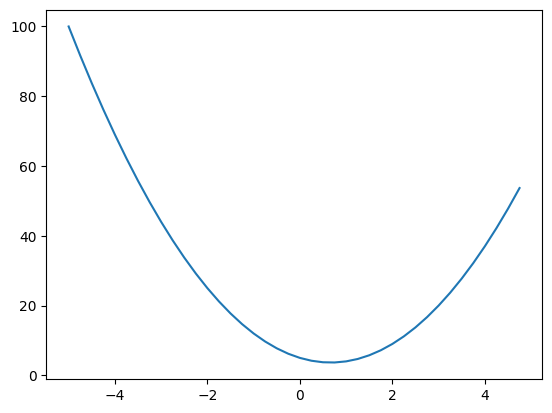

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [3]:
def dX(x, h):
    return (f(x + h) - f(x)) / h

print(dX(3, 0.00000001))
print(dX(-3, 0.00000001))
print(dX(2/3, 0.00000001))

14.00000009255109
-22.00000039920269
0.0


In [4]:
#  let's get more complex
a = 2.0
b = -3.0
c = 10.0
h = 0.00000001

def f(a, b, c):
    return a*b + c

d = f(a, b, c)
print("d: ", d)

d1 = f(a, b, c)
d2 = f(a+h, b, c)

print("d1: ", d1)
print("d2: ", d2)
print("slope of a: ", (d2-d1)/h)

d2 = f(a, b+h, c)
print("slope of b: ", (d2-d1)/h)

d2 = f(a, b, c+h)
print("slope of c: ", (d2-d1)/h)

d:  4.0
d1:  4.0
d2:  3.99999997
slope of a:  -2.999999981767587
slope of b:  1.999999987845058
slope of c:  1.000000082740371


### Starting the core Value object of the neural network and its visualization

In [5]:
class Value:

  def __init__(self, data, _children = (), _op = '', label = None):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    """
    self.grad: maintains the derivative of the output with respect to the value
               default: derivative of a constant is 0
    """
    self.grad = 0.0
    """
    self._backward: implements the chain-rule on each node in the graph by calculating
                    the produced output's gradient into the input's gradient
                    default: empty function for a standard leaf node
    """
    self._backward = lambda: None


  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out
  
  def __radd__(self, other):  # other + self
    return self + other
  
  def __neg__(self):
    return self * -1
  
  def __sub__(self, other):
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out
  
  def __rmul__(self, other):  # other * self
    return self * other
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), "exp")

    def _backward():
      self.grad += out.data * out.grad

    out._backward = _backward
    return out
  
  def __truediv__(self, other):
    return self * other ** -1
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** other, (self,), f"**{other}")

    def _backward():
      self.grad += (other * self.data ** (other-1)) * out.grad

    out._backward = _backward
    return out
  
  def tanh(self):
    """ source: https://en.wikipedia.org/wiki/Hyperbolic_functions#Definitions """
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")

    def _backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward
    return out
  
  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)

    build_topo(self)

    self.grad = 1.0

    for node in reversed(topo):
        node._backward()

In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # LR = left to right

  nodes, edges = trace(root)

  for n in nodes:
    uid = str(id(n))
    label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad)

    # for any value in the graph, create a visual node for it
    dot.node(uid, label=label, shape="record")

    if n._op:
      # if the node has an operation, create an op node for it
      dot.node(name=uid + n._op, label=n._op)
      # and connect the op node to the value node
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

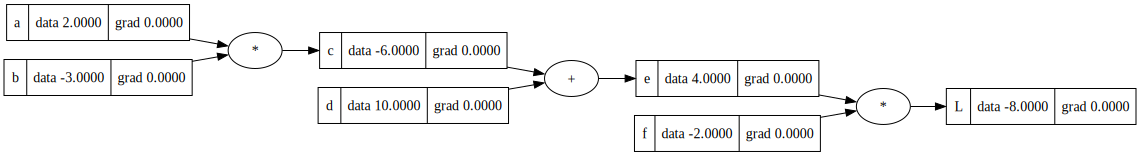

In [7]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = a*b; c.label="c"
d = Value(10.0, label="d")
e = d + c; e.label="e"
f = Value(-2.0, label="f")
L = e * f; L.label="L"

draw_dot(L)

### Manual Backpropagation Example #1: Simple Expression

Backpropagation is a recursive application of the chain-rule from calculus backwards thru the computation graph, in order to compute the gradient of the loss function with respect to the weights of a neural network. This is a simple example of how to do it manually.

Start at the end and calculate the gradient along all intermediate values ie. compute the derivative of each node with respect to the final output. This is the loss function of L with respect to the weights of a neural network in order to know how these weights are impacting the loss function.

In [8]:
def lol():
    """ Gating function for manual numerical approximation of gradients """
    h = 0.001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    d = a*b; d.label="d"
    e = d + c; e.label="e"
    f = Value(-2.0, label="f")
    L = e * f; L.label="L"
    L1 = L.data

    a = Value(2.0 + h, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    d = a*b; d.label="d"
    e = d + c; e.label="e"
    f = Value(-2.0, label="f")
    L = e * f; L.label="L"
    L2 = L.data

    print((L2 - L1) / h)

lol()

6.000000000000227


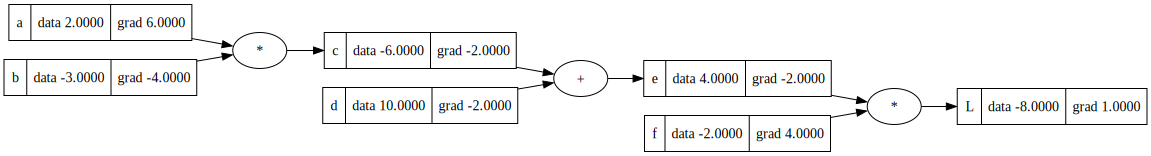

In [9]:
"""
gradient : the slope of the tangent line of the function (aka derivative) at a point
gradient descent : process of finding the minimum of a function

Proof of derivative: https://www.youtube.com/watch?v=VMj-3S1tku0&t=27s (35:13)
"""
L.grad = 1.0                # dL/dL
f.grad = e.data             # dL/df
e.grad = f.data             # dL/de
d.grad = f.data             # dL/dd = de/dd * dL/de (chain-rule)
c.grad = f.data             # dL/dc = de/dc * dL/de (chain-rule)
b.grad = a.data * c.grad    # dL/db = dc/db * dL/dc (chain-rule)
a.grad = b.data * c.grad    # dL/da = dc/da * dL/dc (chain-rule)
draw_dot(L)

Preview of a single optimization step: nudge inputs in the direction of the gradient to cause a positive influence on L.

Gradients enable us to know how to influence the final outcome of a function, thus optimizing the inputs of a function to minimize or maximize the output of that function. This is the basis of neural networks, where we optimize the weights and biases of a network to minimize the loss function.

In [10]:
step_size = 0.01

a.data += a.grad * step_size
b.data += b.grad * step_size
c = a * b
d.data += d.grad * step_size
e = d + c
f.data += f.grad * step_size
L = e * f
print(L)

Value(data=-7.286496)


### Manual Backpropagation Example #2: A Neuron

Neural networks are multi-layered perceptrons, or neurons. A neuron is a function that takes in a vector of inputs and produces a single output. The output is a weighted sum of the inputs, plus a bias term, passed through an activation function. The weights and bias are the parameters of the neuron, and are what we will be optimizing.

The bias term expresses the innate trigger-happiness of the neuron (regardless of the input), while the activation function is some sort of squashing function, e.g. sigmoid, tanh, relu, etc.

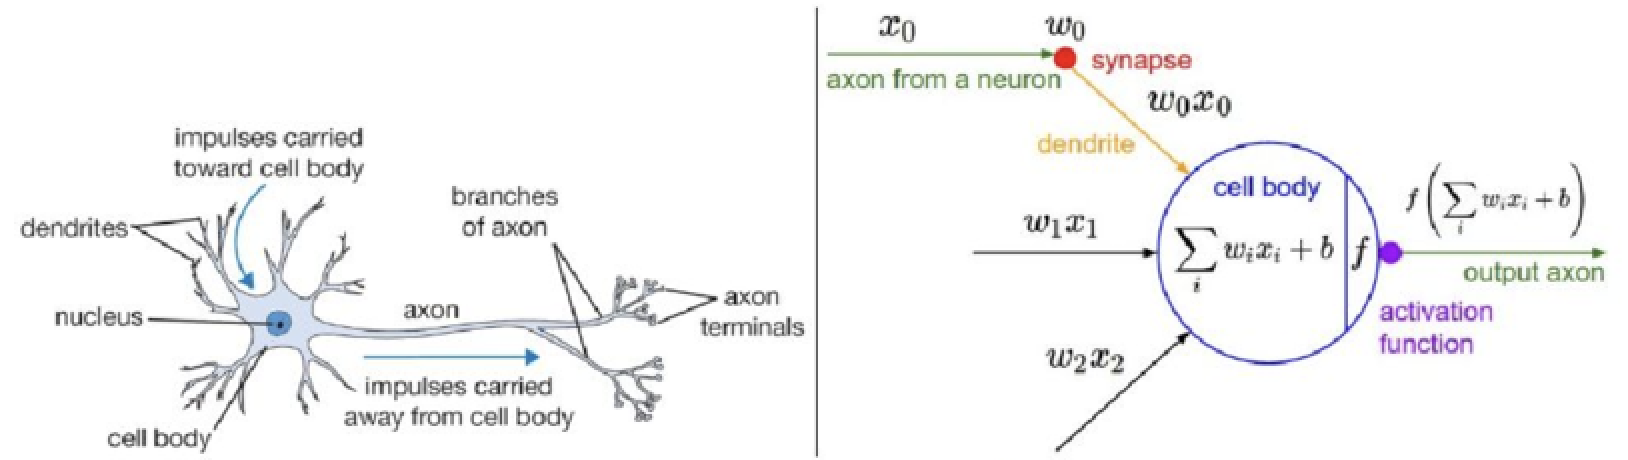

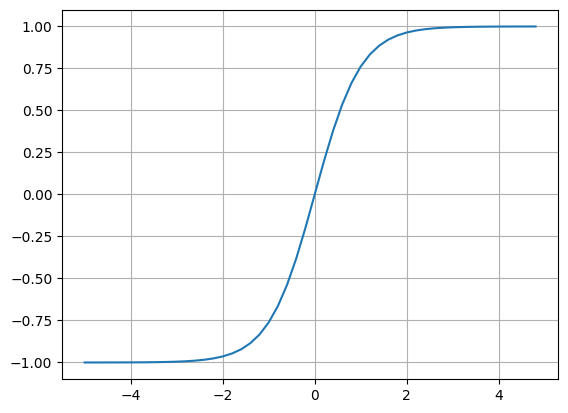

In [11]:
# tanh function aka squashing function
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [12]:
# two dimensions (dendrites) of the neuron
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights (or synapses) of the neuron
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# the neuron's bias
b = Value(6.8813735870195432, label="b")

# the cell body of the neuron (linear combination of inputs weighted by synapses)
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2 + b; n.label = "n"

# the output of the neuron after activation function is applied (here, tanh)
o = n.tanh(); o.label = "o"

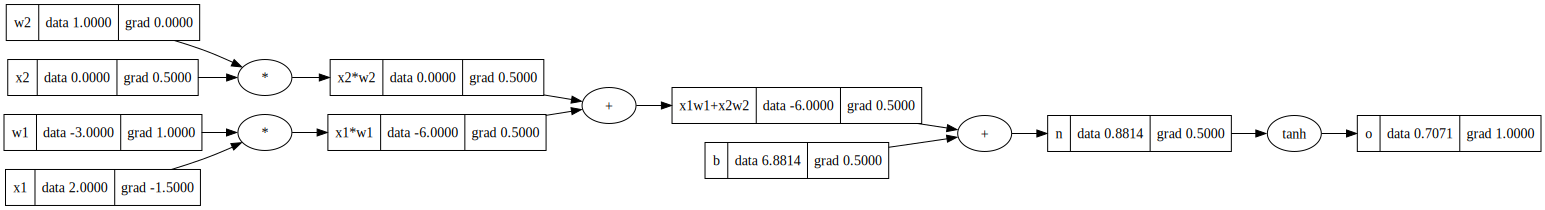

In [13]:
""" source: https://en.wikipedia.org/wiki/Hyperbolic_functions#Derivatives """

o.grad = 1.0                     # do/do
n.grad = 1 - o.data**2           # do/dn = 1 - tanh(n)**2
b.grad = n.grad                  # do/db = dn/db * do/dn (chain-rule)
x1w1x2w2.grad = n.grad           # do/dx1w1x2w2 = dn/dx1w1x2w2 * do/dn (chain-rule)
x2w2.grad = x1w1x2w2.grad        # do/dx2w2 = dx1w1x2w2/dx2w2 * do/dx1w1x2w2 (chain-rule)
x1w1.grad = x1w1x2w2.grad        # do/dx1w1 = dx1w1x2w2/dx1w1 * do/dx1w1x2w2 (chain-rule)
x2.grad = w2.data * x2w2.grad    # do/dx2 = dx2w2/dx2 * do/dx2w2 (chain-rule)
w2.grad = x2.data * x2w2.grad    # do/dw2 = dx2w2/dw2 * do/dx2w2 (chain-rule)
x1.grad = w1.data * x1w1.grad    # do/dx1 = dx1w1/dx1 * do/dx1w1 (chain-rule)
w1.grad = x1.data * x1w1.grad    # do/dw1 = dx1w1/dw1 * do/dx1w1 (chain-rule)

draw_dot(o)

### Implementing the backward function for each operation

In [14]:
# two dimensions (dendrites) of the neuron
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights (or synapses) of the neuron
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# the neuron's bias
b = Value(6.8813735870195432, label="b")

# the cell body of the neuron (linear combination of inputs weighted by synapses)
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2 + b; n.label = "n"

# the output of the neuron after activation function is applied (here, tanh)
o = n.tanh(); o.label = "o"

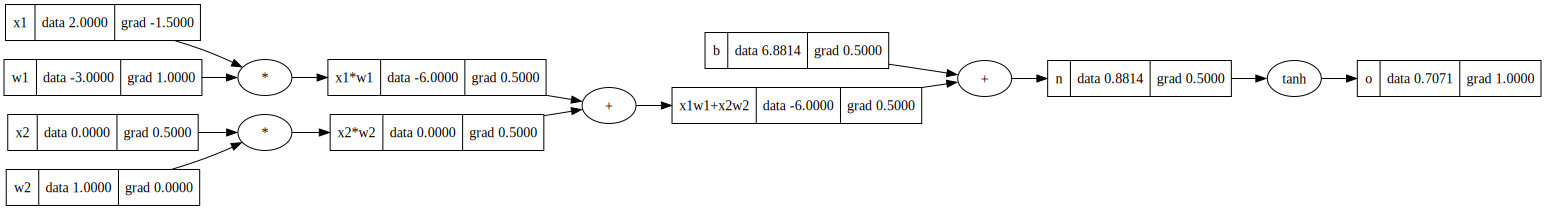

In [15]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

draw_dot(o)

### Implementing the backward function for a whole neuron

Topological sort : laying out a graph such as all the edges go from left to right
                  
source: https://en.wikipedia.org/wiki/Topological_sorting

In [16]:
# two dimensions (dendrites) of the neuron
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights (or synapses) of the neuron
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# the neuron's bias
b = Value(6.8813735870195432, label="b")

# the cell body of the neuron (linear combination of inputs weighted by synapses)
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2 + b; n.label = "n"

# the output of the neuron after activation function is applied (here, tanh)
o = n.tanh(); o.label = "o"

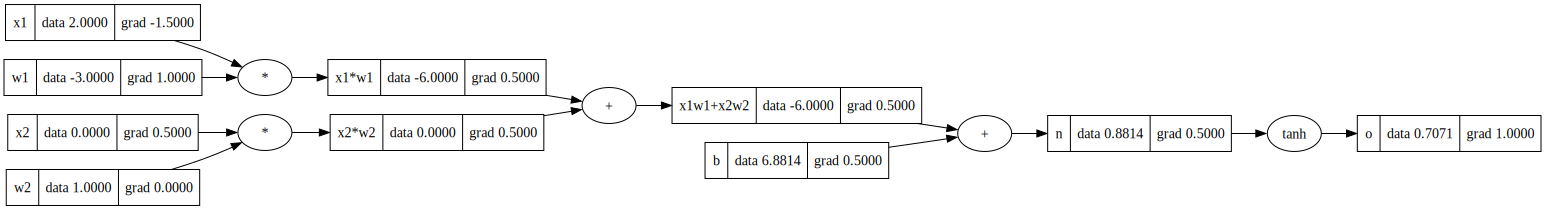

In [17]:
o.backward()

draw_dot(o)

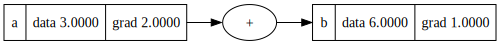

In [18]:
# another example using the same object to compute the gradient
a = Value (3.0, label="a")
b = a + a; b.label = "b"
b.backward()
draw_dot(b)

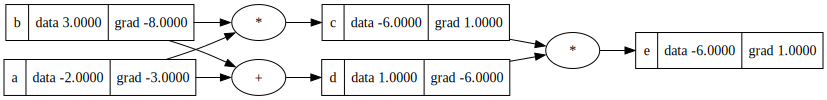

In [19]:
# another example using the same object to compute the gradient
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
c = a * b; c.label = "c"
d = a + b; d.label = "d"
e = c * d; e.label = "e"

e.backward()

draw_dot(e)

### Breaking up a tanh, exercising with more operations

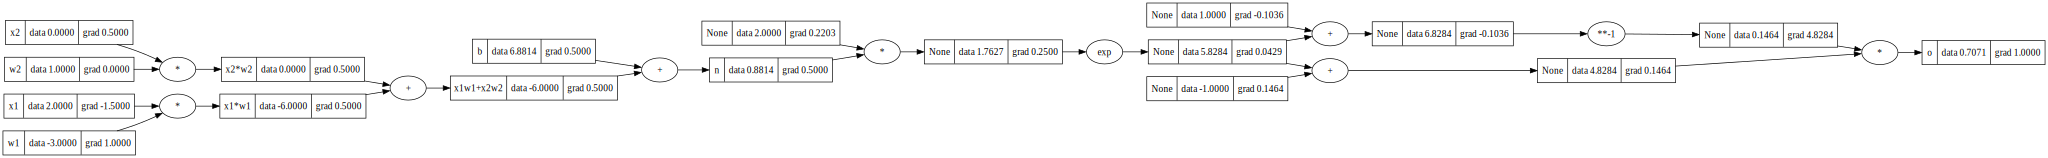

In [20]:
# two dimensions (dendrites) of the neuron
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights (or synapses) of the neuron
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# the neuron's bias
b = Value(6.8813735870195432, label="b")

# the cell body of the neuron (linear combination of inputs weighted by synapses)
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2 + b; n.label = "n"

# the output of the neuron after activation function is applied (here, hyperbolic tangent)
o_step = (2 * n).exp()
o = (o_step - 1) / (o_step + 1)
o.label = "o"

o.backward()
draw_dot(o)

### Doing the same thing using PyTorch: a comparison

In [21]:
import torch

x1 = torch.tensor([2.0]).double()                 ; x1.requires_grad = True
w1 = torch.tensor([-3.0]).double()                ; w1.requires_grad = True
x2 = torch.tensor([0.0]).double()                 ; x2.requires_grad = True
w2 = torch.tensor([1.0]).double()                 ; w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double()   ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("------------------")
print("x2: ", x2.grad.item())
print("w2: ", w2.grad.item())
print("x1: ", x1.grad.item())
print("w1: ", w1.grad.item())

0.7071066904050358
------------------
x2:  0.5000001283844369
w2:  0.0
x1:  -1.5000003851533106
w1:  1.0000002567688737


### Building out a neural net library (multi-layer perceptron - MLP)

A layer of neurons in a neural network is a set of neurons, not connected to each other, but connected to the same inputs. The output of a layer is a vector of outputs of each neuron in the layer.

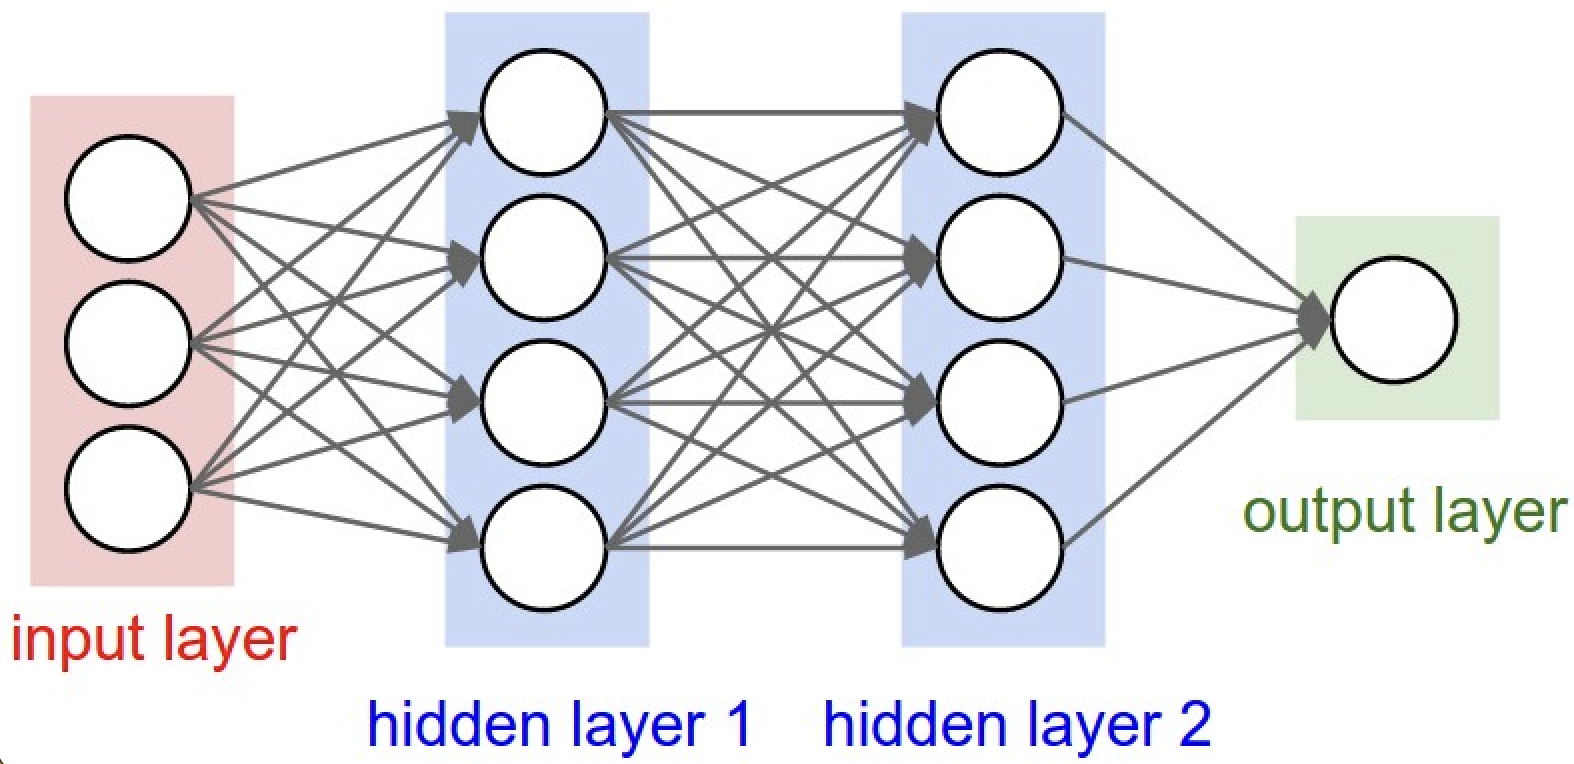

In [22]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((x_i*w_i for x_i, w_i in zip(x, self.w)), self.b)
        return act.tanh()
    
    def parameters(self):
        return self.w + [self.b]

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.970284618559083)

In [23]:
class Layer:
    def __init__(self, n_in, n_out):
      self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
      outs = [n(x) for n in self.neurons]
      return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
      return [p for n in self.neurons for p in n.parameters()]

x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.7895312206014498),
 Value(data=-0.9485996006599318),
 Value(data=0.935838115379216)]

In [24]:
class MLP:
    def __init__(self, nin, nouts):
      """ size of the layers in the MLP """
      size = [nin] + nouts
      self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
      for layer in self.layers:
        x = layer(x)
      return x
    
    def parameters(self):
      return [p for l in self.layers for p in l.parameters()]

In [25]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8616770137079692)

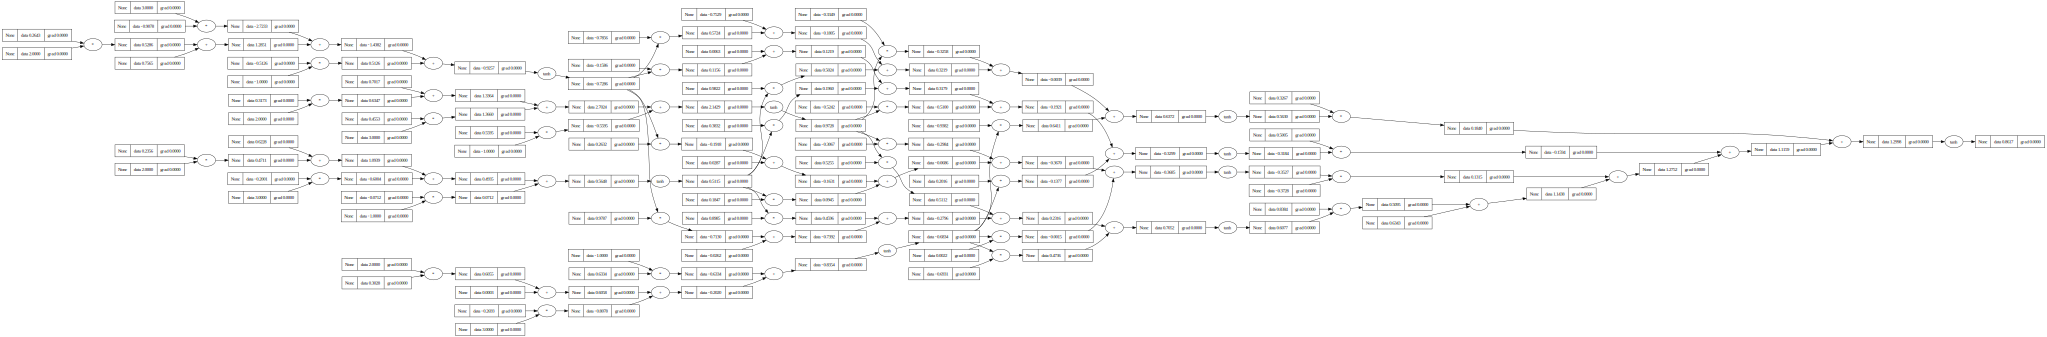

In [26]:
draw_dot(n(x))

### Creating a tiny dataset, writing the loss function

Loss: number that measures the total performance of a neural network on its targets, thus measuring how well the NN is performing. The loss is a function of the weights and biases of the NN and it is the loss that we want to minimize.

For a better understanding, consider a dataset of inputs and their respective outputs (ground truths). When compared to the outputs of the NN, the loss function will calculate the difference between the two and then square it to get rid of the negative values. The loss function will then sum all the squared differences and divide by the number of samples in the dataset to get the average loss. The lower the loss, the better the NN is performing.

In [27]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]   # desired targets

y_pred = [n(x) for x in xs]
y_pred

[Value(data=0.8616770137079692),
 Value(data=0.7552333950889201),
 Value(data=0.4811605559229347),
 Value(data=0.8164422259059819)]

In [28]:
# implement mean squared-error loss function
loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, y_pred)])
loss

Value(data=5.32750756862441)

<strong>Magic happens here!!<strong>

Once backprogation is calculated for the loss function, the gradients of the weights and biases of the NN are known. The gradients are then used to update the weights and biases of the NN in order to minimize the loss function and therefore improve the performance of the NN.

In [29]:
loss.backward()

In [30]:
n.layers[0].neurons[0].w[0].grad

0.4230281862653156

In [31]:
n.layers[0].neurons[0].b.grad

0.864469396666854

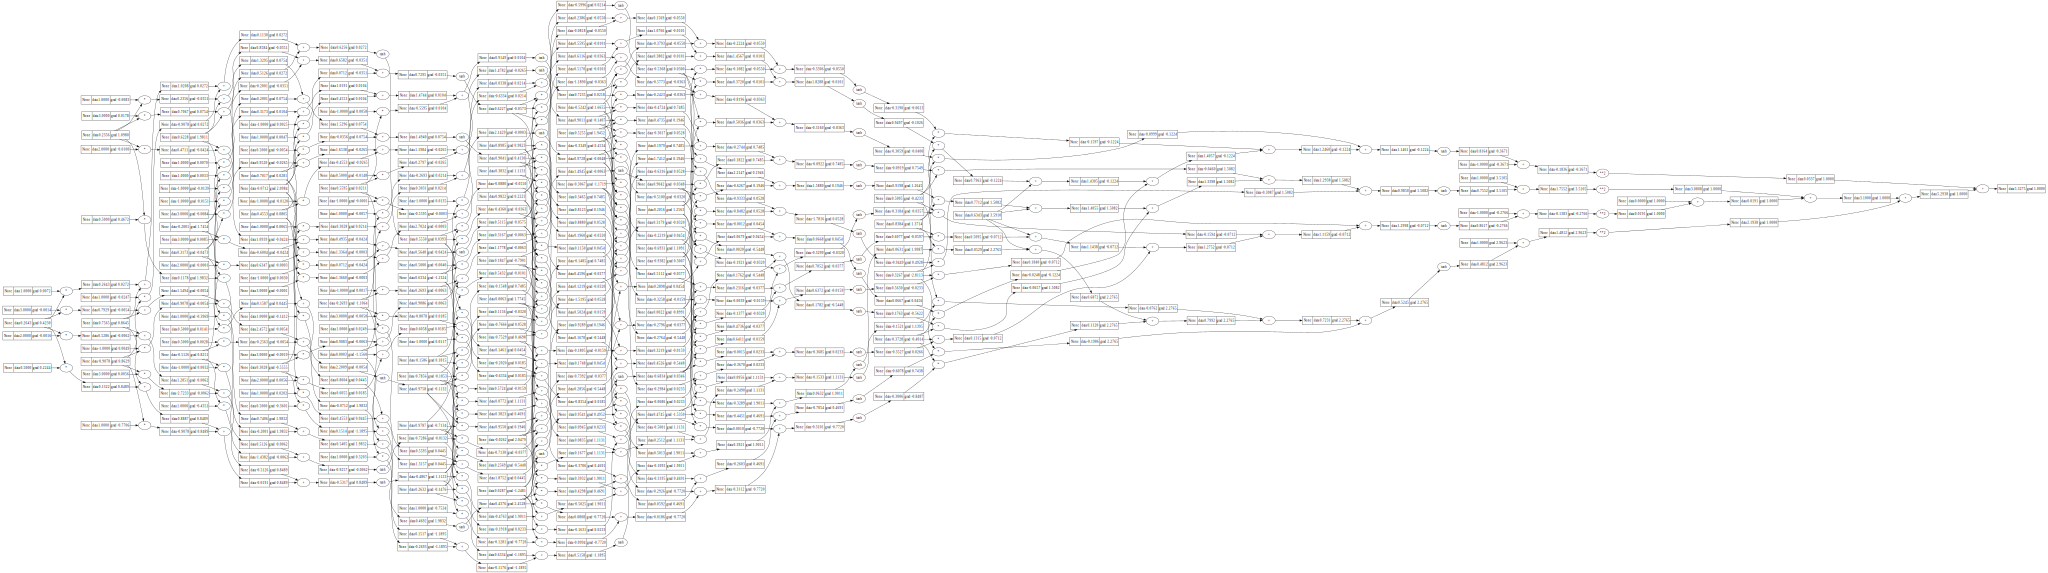

In [32]:
draw_dot(loss)

### Doing gradient descent optimization manually, training the neural net

Gradient descent optimization is the process of updating the weights and biases of a NN in order to minimize the loss function and therefore improve the performance of the NN. It is the process of finding the minimum of a function by taking steps proportional to the negative of the gradient of the function at the current point (ie, itteratively doing forward pass, backward pass, update parameters). In other words, for all the parameters in the neural net, change its value according to the gradient information.

The step of updating should be done in small increments, otherwise the loss function will not converge to a minimum. The size of the step is called the learning rate. If the increment in the step is too small, the loss function will take a long time to converge to a minimum. If the increment in the step is too big, the loss function will not converge to a minimum.

In [33]:
len(n.parameters())

41

In [34]:
loss_data = 1.0

while loss_data > 0.0001:
    # forward pass
    y_pred = [n(x) for x in xs]
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, y_pred)])

    # backward pass
    for p in n.parameters():
      p.grad = 0.0
    loss.backward()

    # update parameters (gradient descent)
    for p in n.parameters():
      p.data -= p.grad * 0.05

    loss_data = loss.data

loss_data

9.998969572180355e-05

In [35]:
y_pred = [n(x) for x in xs]
y_pred

[Value(data=0.996107229149483),
 Value(data=-0.9960116341943762),
 Value(data=-0.99386855195658),
 Value(data=0.9944047135915951)]

In [36]:
ys

[1.0, -1.0, -1.0, 1.0]

### Wrap up

Neural nets are mathematical expressions that take data, weights and parameters as inputs and produce forward passes, in which the gradients of each inputs are calculated. 

This is followed by a loss function that tries to measure the accuracy of the predictions. Usually, the loss will be low when the predictions are matching the targets.

Then, in the backward passes, backpropagation is calculated for the loss function, the gradients of the weights and parameters of the NN are wiggled and tuned in order to minimize the loss function.

Finally, the neural net is updated and the process is repeated until the loss function is at a minimal, which is called gradient descent, ie. follow the gradient information that minimizes the loss.

In production, evaluation of the gradient and the gradient descent would be identical, updates would be performed in batches and use different methods than the stochastic gradient descent used here and the loss function would be performed using cross-entropy loss, not the mean-squared error.

In the end of the day, neural nets are a blob of simulated neural tissue that can do arbitrary things. This is a very tiny network with 41 parameters, compared with the billions of parameters of a real neural network. The explanation for its "emergent properties" is not yet known.

### Sources:

https://www.youtube.com/watch?v=VMj-3S1tku0&t=5195s

https://github.com/karpathy/micrograd